# Основная информация проекта

## Описание датасета

1. **Restaurant_id** — идентификационный номер ресторана / сети ресторанов;
2. **City** — город, в котором находится ресторан;
3. **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
4. **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;
5. **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
6. **Price Range** — диапазон цен в ресторане;
7. **Number of Reviews** — количество отзывов о ресторане;
8. **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;
9. **URL_TA** — URL страницы ресторана на TripAdvisor;
10. **ID_TA** — идентификатор ресторана в базе данных TripAdvisor.

**Целевая переменная** - "Rating"

# Импорт библиотек и загрузка данных

In [1]:
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
RANDOM_SEED = 42
CURRENT_DATE = datetime.now()

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
df_worldcities = pd.read_csv('worldcities.csv')
df_data_plus = pd.read_csv('TripAdvisorPlus.csv')

# Функции для обработки и анализа данных

In [5]:
def find_null(col):
    '''Функция подсчёта количества пустых значений в столбцах датасета'''
    empty_values = data[col].isna().sum()
    print(
        f"В столбце '{col}' количество пропусков = {empty_values}.")
    return empty_values

In [6]:
def last_date(x):
    '''Функция для определния последнего дня отзыва'''
    if len(x) > 0:
        return x[0]
    else:
        return 0

In [7]:
def row_to_datetime(row):
    '''Функция для преобразования данных в списке в формат даты'''
    new_row = []
    if len(row) > 0:
        for i in row:
            new_row.append(pd.to_datetime(i, errors='coerce'))
        return new_row
    else:
        return []

In [8]:
def delta_datetime(row):
    '''Функция подсчёта разницы между датами'''
    if len(row) == 2:
        return (row[0]-row[1]).days
    else:
        return 0

In [9]:
def parsing_all_columns_data(data):
    '''Функция для анализа всех столбцов на количество 
    уникальных значений и количество пропусков'''

    for col in data.columns:
        unique_values = len(data[col].value_counts())
        empty_values = data[col].isna().sum()
        print(
            f"В столбце '{col}' уникальных значений = {unique_values} ,а количество пропусков = {empty_values}.")
        print(
            f'Процент пропусков = {round(empty_values*100/data.shape[0],1)}%')

In [10]:
def review_to_date(review):
    '''Функция для поиска даты в отзывах и 
    преобразование её в тип - datetime
    '''
    pattern = re.compile('\'\d+\/\d+\/\d+\'?')
    dat = pattern.findall(review)
    datetime_list = []
    if len(dat) >= 2:
        for date in dat:
            date = date[1:-1]
            dt = datetime.strptime(date, '%m/%d/%Y')
            datetime_list.append(dt)
        return datetime_list
    else:
        for date in dat:
            date = date[1:-1]
            dt = datetime.strptime(date, '%m/%d/%Y')
            datetime_list.append(dt)
        return datetime_list

In [11]:
def last_date(x):
    '''Функция для получение даты последнего отзыва'''
    if len(x) > 0:
        return x[0]
    else:
        return 0

In [12]:
def days_count(date):
    '''Функция для подсчёта количества прошедших дней 
    с публикации последнего отзыва
    '''
    if date != 0:
        return (CURRENT_DATE - date).days
    else:
        return 0

In [13]:
def delta_datetime(row):
    '''Функция для вычисления количества дней 
    между двумя последними отзывами
    '''
    if len(row) == 2:
        return (row[0]-row[1]).days
    else:
        return 0

In [14]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки
    df_output.drop(['restaurant_id', 'id_ta', ], axis=1, inplace=True)

    # ################### 2. NAN ##############################################################
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    #df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....

    # ################### 3. Encoding ##############################################################
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    #df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....

    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....

    # ################### 5. Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [
        s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis=1, inplace=True)

    return df_output

# Обзор данных

In [15]:
display(df_train.head(5))
df_train.info()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [16]:
display(df_test.head(5))
df_test.info()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [17]:
display(sample_submission.head(5))
sample_submission.info()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [18]:
display(df_worldcities.head(5))
df_worldcities.info()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41001 entries, 0 to 41000
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        41001 non-null  object 
 1   city_ascii  41001 non-null  object 
 2   lat         41001 non-null  float64
 3   lng         41001 non-null  float64
 4   country     41001 non-null  object 
 5   iso2        40970 non-null  object 
 6   iso3        41001 non-null  object 
 7   admin_name  40902 non-null  object 
 8   capital     9483 non-null   object 
 9   population  40263 non-null  float64
 10  id          41001 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 3.4+ MB


In [19]:
display(df_data_plus.head(5))
df_data_plus.info()

,url,rate5,rate4,rate3,rate2,rate1
0,https://www.tripadvisor.ru/Restaurant_Review-g...,0,0,1,0,0
1,https://www.tripadvisor.ru/Restaurant_Review-g...,25,10,8,8,0
2,https://www.tripadvisor.ru/Restaurant_Review-g...,0,1,0,0,0
3,https://www.tripadvisor.ru/Restaurant_Review-g...,46,20,7,1,2
4,https://www.tripadvisor.ru/Restaurant_Review-g...,3,8,2,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43508 entries, 0 to 43507
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     43508 non-null  object
 1   rate5   43508 non-null  int64 
 2   rate4   43508 non-null  int64 
 3   rate3   43508 non-null  int64 
 4   rate2   43508 non-null  int64 
 5   rate1   43508 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 2.0+ MB


In [20]:
df_data_plus['url'] = df_data_plus['url'].apply(lambda x: re.sub(r'https://www.tripadvisor.ru','',x))
df_data_plus.head(5)

,url,rate5,rate4,rate3,rate2,rate1
0,/Restaurant_Review-g189158-d8758873-Reviews-Li...,0,0,1,0,0
1,/Restaurant_Review-g186525-d13129638-Reviews-B...,25,10,8,8,0
2,/Restaurant_Review-g274887-d8286886-Reviews-Be...,0,1,0,0,0
3,/Restaurant_Review-g274924-d1112354-Reviews-Ma...,46,20,7,1,2
4,/Restaurant_Review-g189934-d12947542-Reviews-B...,3,8,2,0,0


Описание оценок путешественников:
   + **rate5** - Отлично
   + **rate4** - Очень хорошо
   + **rate3** - Неплохо
   + **rate2** - Плохо
   + **rate1** - Ужасно

In [21]:
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [22]:
data['rate5'] = data['URL_TA'].map(
    df_data_plus.set_index('url').to_dict()['rate5'])
data['rate4'] = data['URL_TA'].map(
    df_data_plus.set_index('url').to_dict()['rate4'])
data['rate3'] = data['URL_TA'].map(
    df_data_plus.set_index('url').to_dict()['rate3'])
data['rate2'] = data['URL_TA'].map(
    df_data_plus.set_index('url').to_dict()['rate2'])
data['rate1'] = data['URL_TA'].map(
    df_data_plus.set_index('url').to_dict()['rate1'])

In [23]:
# Оставим города с численностью населения больше 400к или где есть столица
df_worldcities = df_worldcities[(df_worldcities['population'] > 400000) | (
    ~pd.isna(df_worldcities['capital']))]

In [24]:
data['Population'] = data['City'].map(
    df_worldcities.set_index('city_ascii').to_dict()['population'])
data['Capital'] = data['City'].map(
    df_worldcities.set_index('city_ascii').to_dict()['capital'])
data['Country'] = data['City'].map(
    df_worldcities.set_index('city_ascii').to_dict()['country'])

In [25]:
# Проверим города с пустым значением численности населения
data[pd.isna(data['Population'])]['City'].unique()

array(['Oporto'], dtype=object)

In [26]:
# Проверим наличие городка в датасети
df_worldcities[df_worldcities['city_ascii'] == 'Oporto']

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id


Возможно произошла ошибка в вводе данных и городо был добавлен неправильно (Oporto == Porto)

In [27]:
# Проверим наличие городка в датасети
df_worldcities[df_worldcities['city_ascii'] == 'Porto']

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
2434,Porto,Porto,41.1495,-8.6108,Portugal,PT,PRT,Porto,admin,237591.0,1620356810


In [28]:
# Заменим некорректное значение
data.replace('Oporto', 'Porto', inplace=True)

In [29]:
# Повторно добавим новые столбцы
data['Population'] = data['City'].map(
    df_worldcities.set_index('city_ascii').to_dict()['population'])
data['Capital'] = data['City'].map(
    df_worldcities.set_index('city_ascii').to_dict()['capital'])
data['Country'] = data['City'].map(
    df_worldcities.set_index('city_ascii').to_dict()['country'])

In [30]:
# Повторно проверим города с пустым значением численности населения
data[pd.isna(data['Population'])]['City'].unique()

array([], dtype=object)

In [31]:
display(data.head(5))
data.info()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,rate5,rate4,rate3,rate2,rate1,Population,Capital,Country
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,NaN,NaN,NaN,NaN,NaN,11020000.0,primary,France
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,NaN,NaN,NaN,NaN,NaN,642045.0,primary,Finland
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,25.0,10.0,8.0,8.0,0.0,488050.0,NaN,United Kingdom
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,89.0,31.0,13.0,4.0,3.0,10979000.0,primary,United Kingdom
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,46.0,20.0,7.0,1.0,2.0,429564.0,primary,Slovakia


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  rate5              37892 non-null  float64
 12  rate4              37892 non-null  float64
 13  rate3              37892 non-null  float64
 14  rate2              37892 non-null  float64
 15  rate1              37892 non-null  float64
 16  Population         500

In [32]:
# Вывод количества строк и столбцов таблицы
print(
    f'Датасет состоит из {data.shape[0]} строк и {data.shape[1]} столбцов')

Датасет состоит из 50000 строк и 19 столбцов


In [33]:
# Приведём наименования колонок в общий вид
data.columns = map(str.lower, data.columns.str.replace(' ', '_', regex=True))

# Работа с данными

## 1. Обработка NAN

In [34]:
parsing_all_columns_data(data)

В столбце 'restaurant_id' уникальных значений = 13094 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'city' уникальных значений = 31 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'cuisine_style' уникальных значений = 10731 ,а количество пропусков = 11590.
Процент пропусков = 23.2%
В столбце 'ranking' уникальных значений = 12975 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'price_range' уникальных значений = 3 ,а количество пропусков = 17361.
Процент пропусков = 34.7%
В столбце 'number_of_reviews' уникальных значений = 1573 ,а количество пропусков = 3200.
Процент пропусков = 6.4%
В столбце 'reviews' уникальных значений = 41857 ,а количество пропусков = 2.
Процент пропусков = 0.0%
В столбце 'url_ta' уникальных значений = 49963 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'id_ta' уникальных значений = 49963 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'sample' уникальных значений = 2 ,а количество 

In [35]:
data['number_of_price_range_isnan'] = pd.isna(
    data['price_range']).astype('uint8')

In [36]:
data['number_of_price_range_isnan']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    1
49998    0
49999    0
Name: number_of_price_range_isnan, Length: 50000, dtype: uint8

In [37]:
# Проверим какие значения присутствуют в столбце price_range
display(data['price_range'].unique())
display(data['price_range'].value_counts())

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

Исходя из количества уникальных значений, можно сделать вывод, что самый распространенный диапозон цен = от 2-3. Заполним пропуски этим значением

In [38]:
data['price_range'].fillna('$$ - $$$', inplace=True)

In [39]:
data['number_of_reviews_isnan'] = pd.isna(
    data['number_of_reviews']).astype('uint8')

In [40]:
data['number_of_reviews_isnan']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: number_of_reviews_isnan, Length: 50000, dtype: uint8

In [41]:
# Заполним пропуски средним значением по городам и ценам
data['number_of_reviews'] = data.groupby(['city', 'price_range'])['number_of_reviews'].transform(
    lambda group: group.fillna(round(group.median())))

In [42]:
data['cuisine_style_isnan'] = pd.isna(data['cuisine_style']).astype('uint8')

In [43]:
data['cuisine_style_isnan']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: cuisine_style_isnan, Length: 50000, dtype: uint8

In [44]:
data['cuisine_style'] = data['cuisine_style'].apply(
    lambda x: eval(x) if not pd.isna(x) else 'Unknown')

In [45]:
# Проверим какие значения присутствуют в столбце capital
display(data['capital'].unique())
display(data['capital'].value_counts())

array(['primary', nan, 'admin', 'minor'], dtype=object)

primary    33425
admin      12017
minor       3813
Name: capital, dtype: int64

Пустая строка, если не столица, в противном случае:
 * primary - столица страны (например, Вашингтон, округ Колумбия);
 * admin - административная столица первого уровня (например, Литл-Рок, штат Арканзас);
 * minor - административная столица нижнего уровня (например, Фейетвиль, штат Арканзас).

In [46]:
data['capital_isnan'] = pd.isna(data['capital']).astype('uint8')

In [47]:
data['capital'] = data['capital'].fillna(0)

In [48]:
data[['rate5','rate4','rate3','rate2','rate1']] = data[['rate5','rate4','rate3','rate2','rate1']].fillna(0)

### 2. Обработка признаков и добавление новых
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [49]:
data.head(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,...,rate3,rate2,rate1,population,capital,country,number_of_price_range_isnan,number_of_reviews_isnan,cuisine_style_isnan,capital_isnan
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0.0,0.0,0.0,11020000.0,primary,France,0,0,0,0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0.0,0.0,0.0,642045.0,primary,Finland,0,0,0,0
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,8.0,8.0,0.0,488050.0,0,United Kingdom,0,0,0,1
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,13.0,4.0,3.0,10979000.0,primary,United Kingdom,0,0,0,0
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,7.0,1.0,2.0,429564.0,primary,Slovakia,0,0,0,0


In [50]:
capital_dict = {'primary': 1, 'admin': 2, 'minor': 3}
data['capital'] = data['capital'].map(lambda x: capital_dict.get(x, x))

In [51]:
value_price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
data['price_range'] = data['price_range'].map(
    lambda x: value_price_dict.get(x, x))

In [52]:
# Выделим числовые значения данных restaurant_id, url_ta, id_ta и создадим соответствующие столбцы
data['new_id_ta'] = data['id_ta'].str[1:].astype(float)
data['new_restaurant_id'] = data['restaurant_id'].str[3:].astype(float)
data['new_url_ta'] = data['url_ta'].str[20:26].astype(float)

In [53]:
# Выделим даты из комментариев и создадим соответствующий столбец
data['reviews'] = data['reviews'].astype(str)
data['review_dates'] = data['reviews'].apply(review_to_date)

In [54]:
# Получим дату последнего отзыва
data['last_reviews_date'] = data['review_dates'].apply(last_date)

In [55]:
# Определим промежуток(в днях) между двумя поледними отзывами
data['delta_datetime'] = data['review_dates'].apply(delta_datetime)

In [56]:
# Определим количество прошедших дней с последнего отзыва
data['days_since_last_review'] = data['last_reviews_date'].apply(days_count)

In [57]:
# Определим количества кухонь в ресторане
data['cuisine_style_count'] = data['cuisine_style'].apply(len)

In [58]:
# Определим среднее количество кухонь в ресторане по городам
data['cuisine_style_mean_count'] = data['city'].map(
    data.groupby('city')['cuisine_style_count'].mean().to_dict())

In [59]:
# Определим средний ранк ресторанов по городам
data['ranking_mean_value'] = data['city'].map(
    data.groupby('city')['ranking'].mean().to_dict())

In [60]:
# Определим количество ресторанов в городах
data['rests_in_city'] = data['city'].map(
    data.groupby(['city'])['new_restaurant_id'].count().to_dict())

In [61]:
# Определим количество ресторанов в стране
data['rests_in_country'] = data['country'].map(
    data.groupby(['country'])['new_restaurant_id'].count().to_dict())

In [62]:
data['relative_ranking_by_city'] = data['ranking'] / data['rests_in_city']

In [63]:
data['relative_ranking_by_country'] = data['ranking'] / data['rests_in_country']

In [64]:
# Определим среднее количество отзывов в ресторанах по городам 
data['mean_number_of_reviews_by_city'] = data['city'].map(
    data.groupby(['city'])['number_of_reviews'].mean().to_dict())

In [65]:
# Определим среднее количество отзывов в ресторанах по странам
data['mean_number_of_reviews_by_country'] = data['country'].map(
    data.groupby(['country'])['number_of_reviews'].mean().to_dict())

In [66]:
data['rests_per_population'] = data['rests_in_city'] / data['population']

In [67]:
# Определим среднее количество оценок
data['traveler_rating'] = data[['rate5','rate4','rate3','rate2','rate1']].mean(axis = 1)

In [68]:
#data['mean_traveler_rating_by_city'] = data['city'].map(
#  data.groupby('city')[['rate5','rate4','rate3','rate2','rate1']].mean().mean(axis = 1).to_dict())

In [69]:
data = pd.get_dummies(data, columns=['city', ], dummy_na=True)

In [70]:
data = pd.get_dummies(data, columns=['country', ], dummy_na=True)

In [71]:
cuisine_data = data[['cuisine_style']].copy()
cuisine_data = pd.get_dummies(
    cuisine_data['cuisine_style'].explode(), prefix='cuis').sum(level=0)
data = pd.concat([data, cuisine_data], axis=1)

Посмотрим данные в restaurant_id

In [72]:
data['restaurant_id'].value_counts()

id_871      19
id_227      19
id_436      19
id_633      19
id_430      18
            ..
id_13895     1
id_4704      1
id_11697     1
id_13134     1
id_14012     1
Name: restaurant_id, Length: 13094, dtype: int64

Судя по количеству повторений id ресторана, можно предположить, что данный ресторан - сетевой.
Созданим новый столбец с этим параметром

In [73]:
chain_restaurant_list = list(data['restaurant_id'].value_counts()[
                             data['restaurant_id'].value_counts() > 1].index)

In [74]:
data['chain_restaurant'] = data[data['restaurant_id'].isin(
    chain_restaurant_list)]['restaurant_id'].apply(lambda x: 1)
data['chain_restaurant'].fillna(0, inplace=True)

In [75]:
data.head(5)

,restaurant_id,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,...,cuis_Uzbek,cuis_Vegan Options,cuis_Vegetarian Friendly,cuis_Venezuelan,cuis_Vietnamese,cuis_Welsh,cuis_Wine Bar,cuis_Xinjiang,cuis_Yunnan,chain_restaurant
0,id_0,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,0,0,0,0,0,1.0
1,id_1,"[European, Scandinavian, Gluten Free Options, ...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,1,1,0,0,0,0,0,0,1.0
2,id_2,[Vegetarian Friendly],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,1,0,0,0,0,0,0,1.0
3,id_3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,1,0,0,0,0,0,0,1.0
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,1,0,0,0,0,0,0,1.0


# EDA 

### Посмотрим распределение признака

<AxesSubplot:>

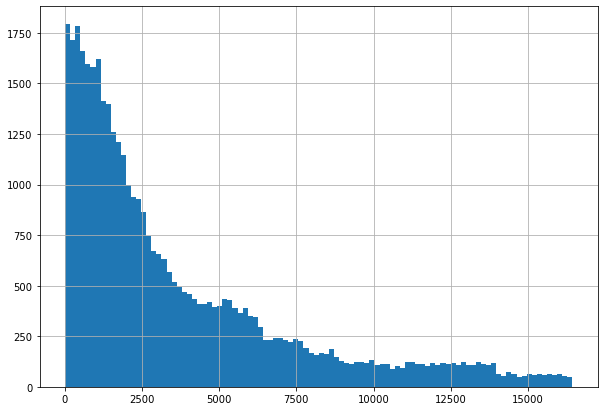

In [76]:
plt.rcParams['figure.figsize'] = (10, 7)
df_train['Ranking'].hist(bins=100)

<AxesSubplot:>

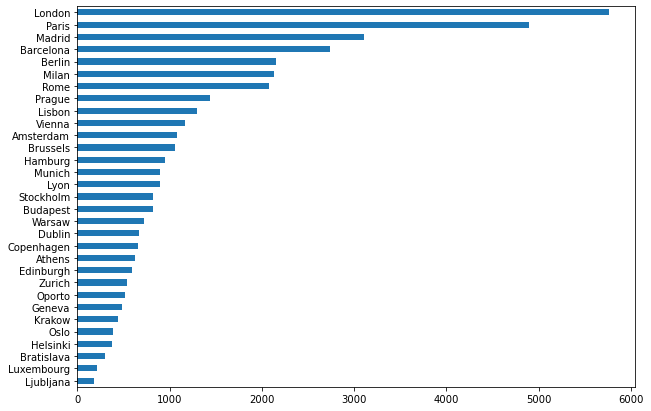

In [77]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

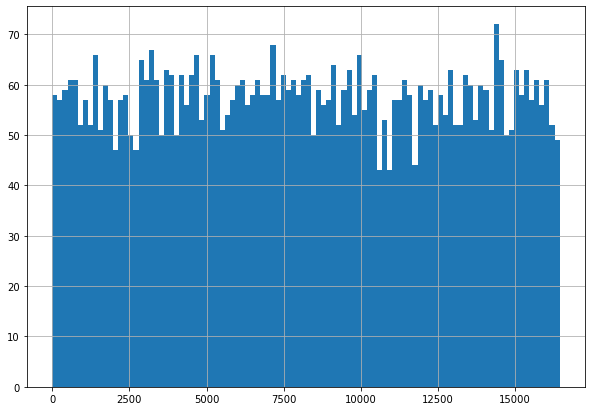

In [78]:
df_train['Ranking'][df_train['City'] == 'London'].hist(bins=100)

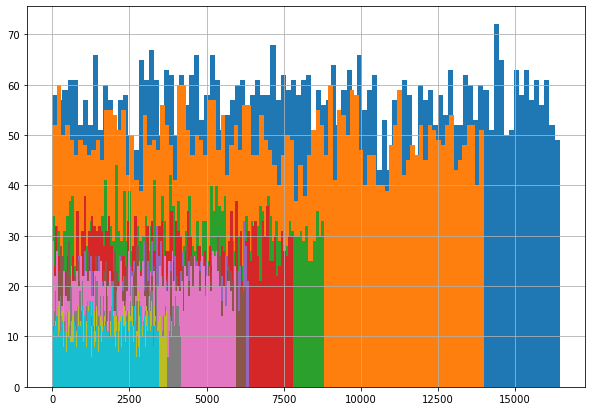

In [79]:
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

## Посмотрим распределение целевой переменной

<AxesSubplot:>

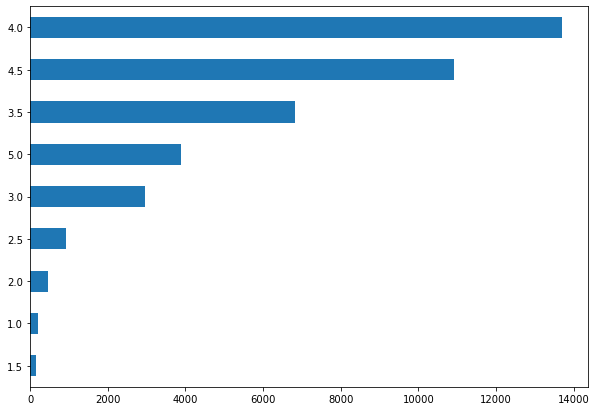

In [80]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

## Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

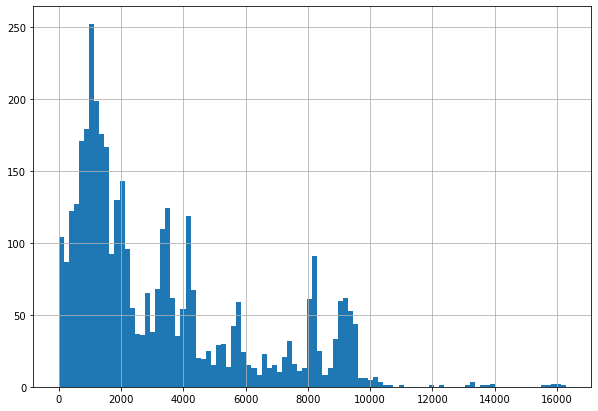

In [81]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

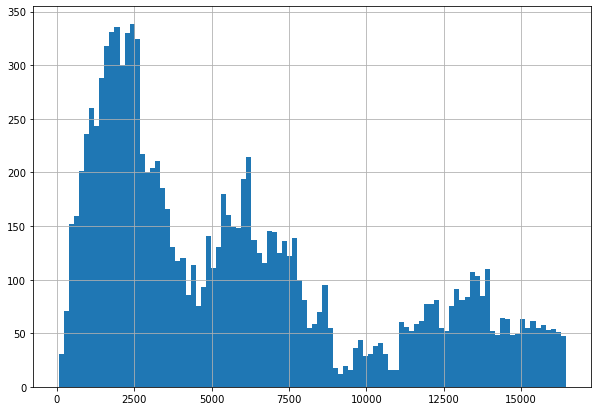

In [82]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

<AxesSubplot:>

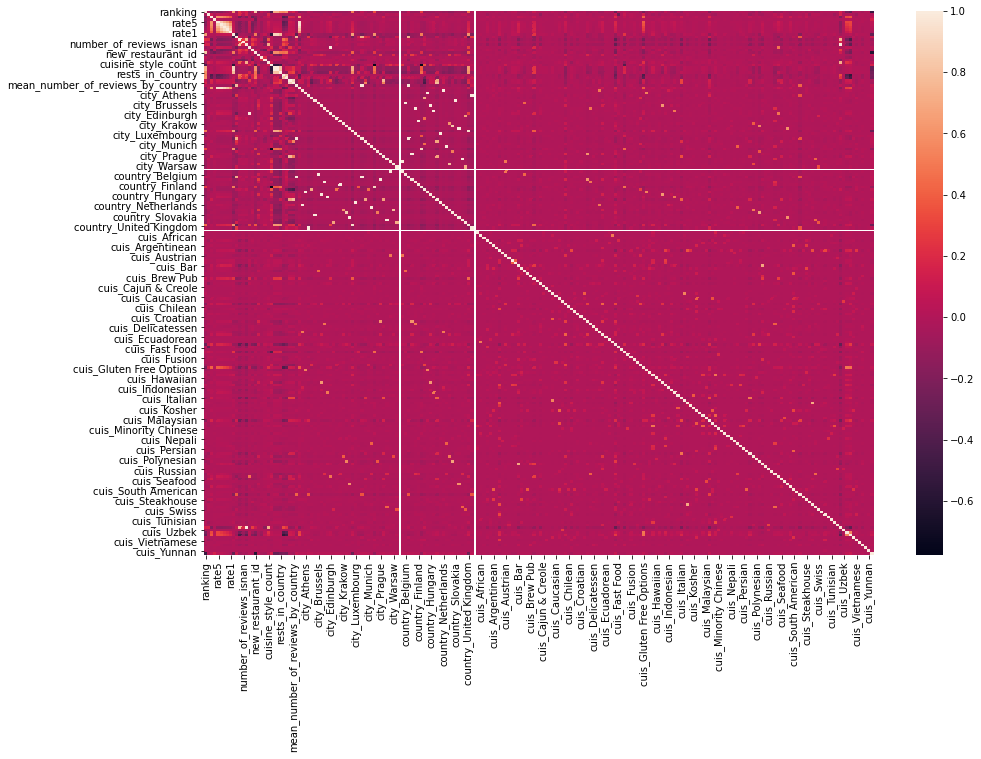

In [83]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing

In [84]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,ranking,price_range,number_of_reviews,sample,rating,rate5,rate4,rate3,rate2,rate1,...,cuis_Uzbek,cuis_Vegan Options,cuis_Vegetarian Friendly,cuis_Venezuelan,cuis_Vietnamese,cuis_Welsh,cuis_Wine Bar,cuis_Xinjiang,cuis_Yunnan,chain_restaurant
47932,6473.0,1,41.0,1,3.5,4.0,0.0,0.0,0.0,3.0,...,0,0,0,0,0,0,0,0,0,1.0
5703,281.0,1,272.0,0,0.0,101.0,63.0,9.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,1.0
14279,1843.0,2,6.0,1,4.0,0.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.0
10548,1974.0,2,9.0,1,4.5,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.0
36531,2368.0,2,9.0,1,4.5,6.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.0
3172,994.0,2,66.0,0,0.0,17.0,5.0,2.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,1.0
5132,907.0,2,70.0,0,0.0,14.0,6.0,0.0,1.0,3.0,...,0,1,1,0,0,0,0,0,0,1.0
31158,1698.0,1,32.0,1,2.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.0
41421,1036.0,2,20.0,1,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.0
29793,1021.0,2,7.0,1,4.5,1.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.0


In [85]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

In [86]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [87]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 214), (40000, 214), (40000, 213), (32000, 213), (8000, 213))

# Model 
Сам ML

In [88]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [89]:
# Создаём модель
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [90]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

y_pred = (y_pred * 2).round()/2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [91]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1525625


In [92]:
y_pred

array([4.5, 5. , 4. , ..., 4.5, 4.5, 4. ])

<AxesSubplot:>

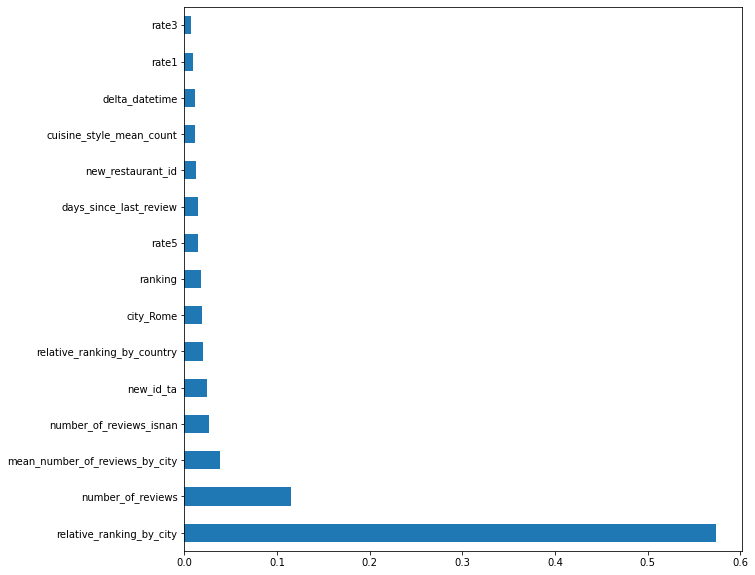

In [93]:
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [94]:
test_data.sample(10)

,ranking,price_range,number_of_reviews,rating,rate5,rate4,rate3,rate2,rate1,population,...,cuis_Uzbek,cuis_Vegan Options,cuis_Vegetarian Friendly,cuis_Venezuelan,cuis_Vietnamese,cuis_Welsh,cuis_Wine Bar,cuis_Xinjiang,cuis_Yunnan,chain_restaurant
3091,1146.0,1,54.0,0.0,1.0,1.0,1.0,0.0,0.0,506654.0,...,0,0,0,0,0,0,0,0,0,1.0
9377,2205.0,2,147.0,0.0,0.0,0.0,0.0,0.0,0.0,1366180.0,...,0,0,0,0,0,0,0,0,0,1.0
7082,1958.0,3,200.0,0.0,0.0,0.0,0.0,0.0,0.0,10979000.0,...,0,0,0,0,0,0,0,0,0,1.0
8381,1273.0,1,120.0,0.0,32.0,7.0,4.0,0.0,0.0,1366180.0,...,0,0,0,0,0,0,0,0,0,1.0
6700,1241.0,2,1830.0,0.0,267.0,267.0,97.0,50.0,28.0,2872800.0,...,0,1,1,0,0,0,0,0,0,1.0
113,1913.0,2,12.0,0.0,5.0,7.0,1.0,1.0,2.0,516092.0,...,0,0,0,0,0,0,0,0,0,1.0
7800,272.0,2,261.0,0.0,0.0,0.0,0.0,0.0,0.0,1173179.0,...,0,1,1,0,0,0,0,0,0,1.0
2393,515.0,2,48.0,0.0,0.0,0.0,0.0,0.0,0.0,488050.0,...,0,0,1,0,0,0,1,0,0,1.0
6223,1141.0,2,26.0,0.0,20.0,6.0,0.0,1.0,3.0,488050.0,...,0,0,0,0,0,0,0,0,0,1.0
2313,7247.0,2,19.0,0.0,1.0,1.0,0.0,0.0,7.0,448016.0,...,0,0,0,0,0,0,0,0,0,1.0


In [95]:
test_data = test_data.drop(['rating'], axis=1)

In [96]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [97]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [98]:
predict_submission = (predict_submission * 2).round()/2
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [99]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,3.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
